## Figure 1

European starling song, tempo measurement, smoothed amplitude envelope

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io.wavfile import read

In [111]:
from starling_rhythm.utils.paths import DATA_DIR, FIGURE_DIR
from pathlib2 import Path

In [112]:
wav_paths = list(Path(DATA_DIR).rglob("*27-520000.wav"))

In [113]:
wav_paths[0]

PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-13_17-15-27-520000.wav')

In [191]:
sr, data = read(wav_paths[0])
data = data[5*48000:-5*48000]

## Write amplitude envelope

In [192]:
from starling_rhythm.utils.audio import extract_amp_env
import numpy as np

In [193]:
amp_env = extract_amp_env(
    data.astype(np.int16), 
    target_sr = 200, ## each number is 5 ms
    win_type = 'boxcar', ## smooth with boxcar window (rolling average)
    res_type = 'linear', ## linear resample
    stds = 1, ## make compact support
    buffer = 100, ## buffer compact support
    spl = True,
    reduce_noise = True,
    #hilbert_artifacts = True
)

In [194]:
def normalize(x, normalize_anchors, newRange=(0, 1)): #x is an array. Default range is between zero and one
    xmin, xmax = normalize_anchors #get max and min from input array
    norm = (x - xmin)/(xmax - xmin) # scale between zero and one
    
    if newRange == (0, 1):
        return(norm) # wanted range is the same as norm
    elif newRange != (0, 1):
        return norm * (newRange[1] - newRange[0]) + newRange[0] #scale to a different range.    
    #add other conditions here. For example, an error message

## Get smoothed amp_env

In [195]:
from scipy.signal import hilbert, get_window

In [196]:
win_type = 'hann'

In [197]:
smoothed_amp_env = np.convolve(amp_env, get_window(win_type, 1000))
smoothed_amp_env = normalize(smoothed_amp_env, (np.min(smoothed_amp_env), np.max(smoothed_amp_env)), newRange = (0, 1))

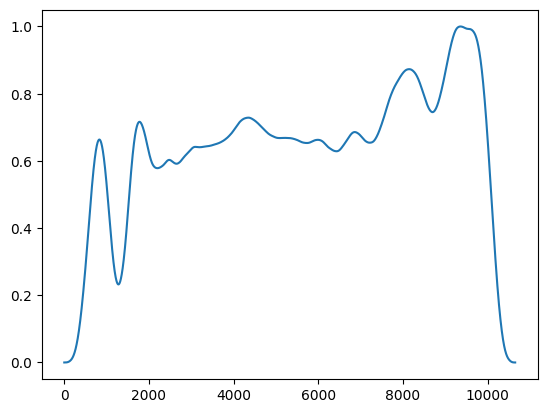

In [198]:
plt.plot(smoothed_amp_env)

## get peak event series

In [199]:
from scipy.signal import find_peaks

In [200]:
peaks, _ = find_peaks(amp_env, height = 0.1)

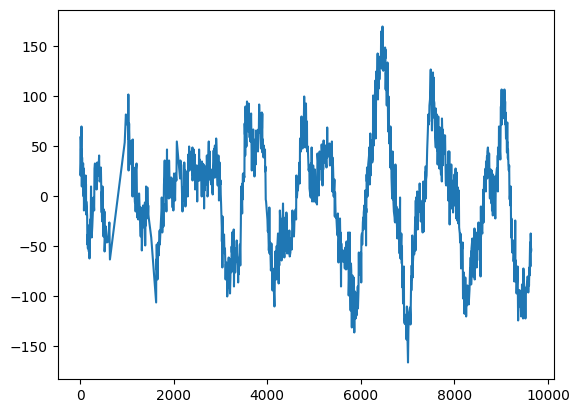

In [201]:
plt.plot(peaks, data[peaks])

In [202]:
def tempo_estimate(peaks):
    tempo = []
    for i in np.arange(len(peaks)):
        try:
            tempo.append(peaks[i+2] - peaks[i])
        except:
            continue
            
    return tempo

In [203]:
tempos = tempo_estimate(peaks)

In [204]:
len(tempos)

1335

In [215]:
smoothed_tempos = np.convolve(tempos, get_window(win_type, 200))

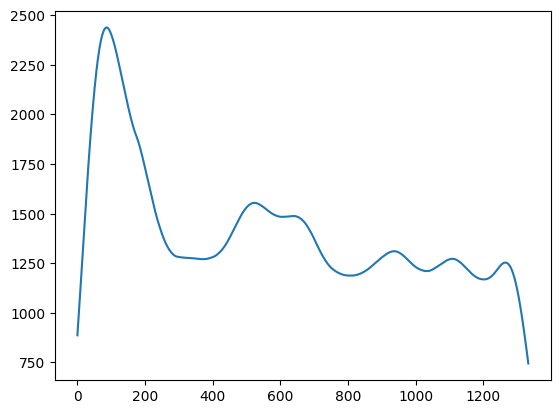

In [216]:
plt.plot(smoothed_tempos[100:-100])

In [217]:
normalize(peaks, normalize_anchors = (0, len(amp_env)), newRange = (0, len(data)/sr))

array([1.08819992e-02, 2.72049981e-02, 4.35279969e-02, ...,
       5.24022673e+01, 5.24457953e+01, 5.24566773e+01])

## plot

In [218]:
from numpy import pi

In [219]:
FIGURE_DIR / 'F1_Starling_qualitative.pdf'

PosixPath('/home/AD/j8xing/starling_rhythm_mfdfa/figures/F1_Starling_qualitative.pdf')

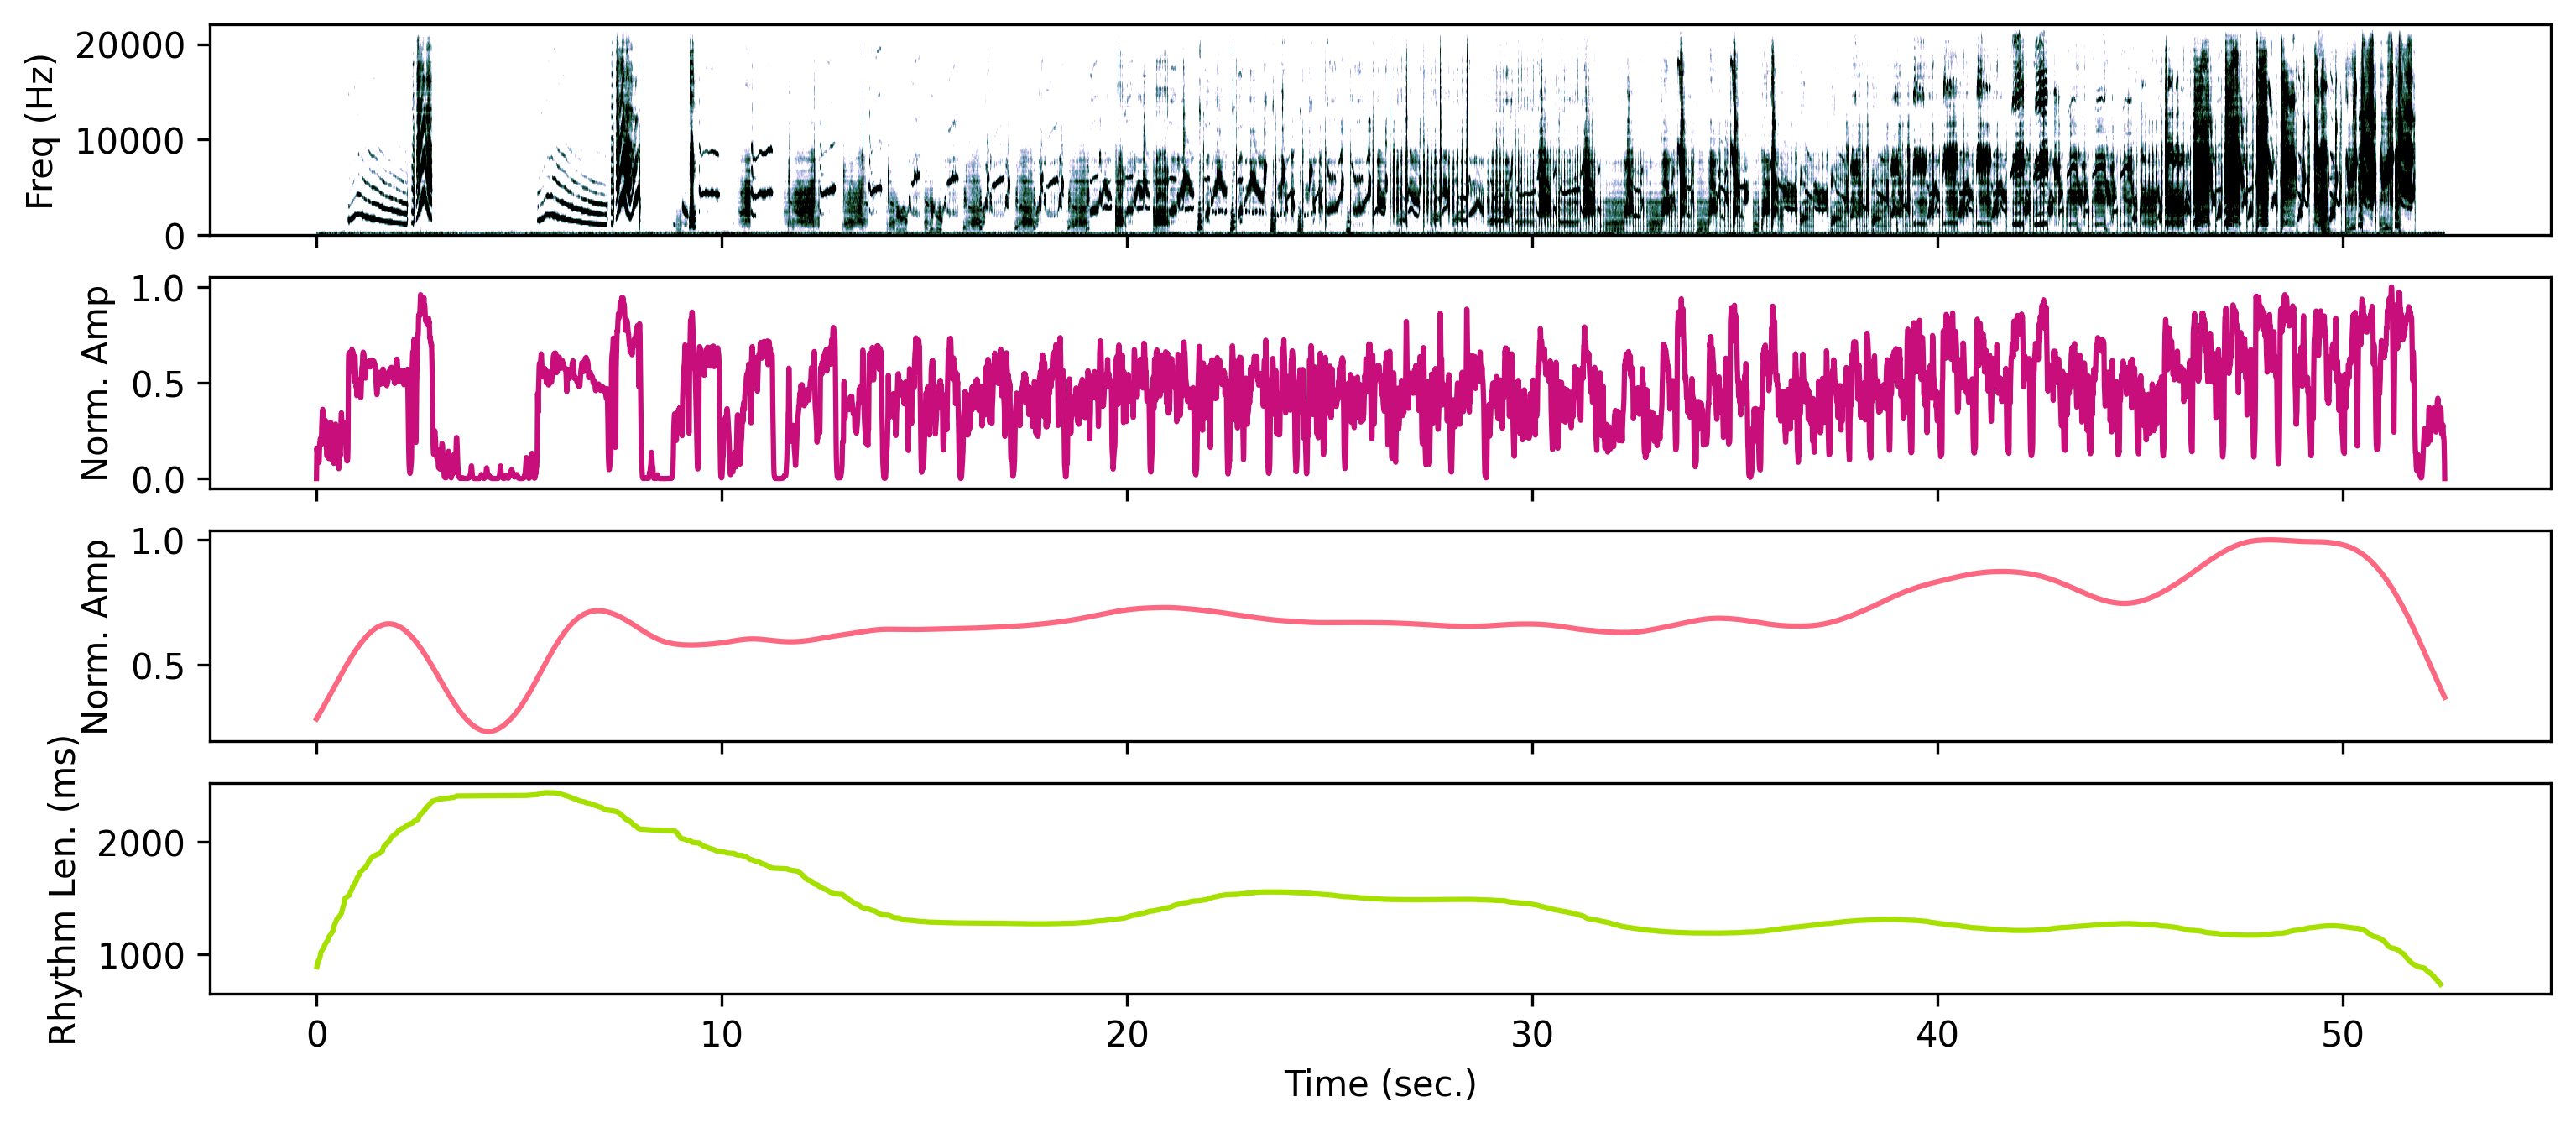

In [221]:
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (12, 5), dpi = 300, sharex = True)


axes[0].specgram(
    data, Fs = sr, cmap = sns.cubehelix_palette(start = 1.75, rot = 0.5, dark = -2.5, light = 7.5, as_cmap=True)
)
axes[0].set_ylabel('Freq (Hz)')

axes[1].plot(
    np.linspace(0, len(data)/sr, len(amp_env)), amp_env, color = '#C70E7B'
)
axes[1].set_ylabel('Norm. Amp')

axes[2].plot(
    np.linspace(0, len(data)/sr, len(amp_env)), smoothed_amp_env[500:-499], color = '#FC6882'
)
axes[2].set_ylabel('Norm. Amp')

axes[3].plot(
    normalize(peaks[:-2], normalize_anchors = (0, len(amp_env)), 
              newRange = (0, len(data)/sr)), 
    smoothed_tempos[100:-99], color = '#A6E000'
)
axes[3].set_ylabel('Rhythm Len. (ms)')
axes[3].set_xlabel('Time (sec.)')

plt.savefig(FIGURE_DIR / 'F1_Starling_qualitative.pdf', dpi = 'figure', format = 'pdf', transparent = True)

## animate

In [71]:
from matplotlib.animation import FuncAnimation

In [82]:
# Define the function to update the x-axis limits of the plot
def update(i):
    start = np.round(i * (1/30), decimals = 1)
    end = np.round(start + 10, decimals = 1)
    axes[0].set_xlim(start, end)
    axes[1].set_xlim(start, end)
    axes[2].set_xlim(start, end)
    axes[3].set_xlim(start, end)

In [83]:
(len(data)/sr) * 30

1657.2755102040817

In [84]:
frames

1657

In [85]:
# Create the animation using FuncAnimation
fps = 30
frames = int((len(data)/sr) * fps)

ani = FuncAnimation(fig, update, frames=range(frames), interval=1000/fps, blit=False)

In [86]:
%%time
# Save the animation as an mp4 video file
ani.save(FIGURE_DIR / 'F1_Starling_qualitative.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

CPU times: user 9min 26s, sys: 10.7 s, total: 9min 36s
Wall time: 9min 49s
